## Classification using siamese model

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [3]:
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Model

## Configurações Globais

In [5]:
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000
epochs = 1000

In [6]:
DOMAIN = 'openoffice'
METHOD = 'baseline_dwen_{}'.format(epochs)
PREPROCESSING = 'bert'
TOKEN = 'bert'
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
SAVE_PATH = '{}_classification({})'.format(METHOD, DOMAIN)
PRETRAINED_MODEL = 'modelos/model_{}_preprocessing_{}_feature_{}epochs_64batch({}).h5'.format(PREPROCESSING, METHOD, str(epochs), DOMAIN)
TEST_PATH = os.path.join(DIR, 'test_classification.txt')

In [7]:
import keras
from keras.models import Model
from keras.layers import Input
from keras.models import load_model
import keras.backend as K

K.clear_session()

"""
    A lista de modelos estar disponível no diretorio /modelos
        name:
            - model_baseline_{X}epoch_{Y}steps_({dataset}).h5
            - model_baseline_{X}epoch_{Y}steps_({dataset}).json
    
        Informações adicionais:
            {X} - total de épocas treinada. Ex: 100, 1000
            {Y} - total de steps validados no treino. Ex: 10, 16
            {dataset} - Nome da base testada. Ex: Eclipse, Netbeans, OpenOffice
"""
similarity_model = load_model(PRETRAINED_MODEL)

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
import keras.backend as K

MAX_SEQUENCE_LENGTH_T = K.int_shape(similarity_model.input[0])[1]
MAX_SEQUENCE_LENGTH_D = K.int_shape(similarity_model.input[1])[1]

MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D

(20, 20)

In [9]:
import os

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [10]:
from keras_bert import load_vocabulary

token_dict = load_vocabulary(vocab_path)

In [11]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, 
                    token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [12]:
baseline.info_dict

{'bug_severity': 6,
 'bug_status': 3,
 'component': 144,
 'priority': 5,
 'product': 41,
 'version': 539}

In [13]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

#### Loading bug ids in memory

In [14]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


98070

#### Loading train bugs

In [15]:
%%time

experiment.load_bugs(TOKEN)


CPU times: user 9.47 s, sys: 1.08 s, total: 10.5 s
Wall time: 10.3 s


In [16]:
%%time
issues_by_buckets = experiment.get_buckets_for_bugs()
experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')


CPU times: user 1.97 s, sys: 19.5 ms, total: 1.99 s
Wall time: 1.98 s


In [17]:
%%time

bug_train_ids = experiment.get_train_ids(baseline.train_data)

CPU times: user 153 ms, sys: 232 µs, total: 153 ms
Wall time: 152 ms


In [18]:
len(bug_train_ids)

2452118

In [19]:
%%time

baseline.test_data, baseline.dup_sets_test = experiment.read_test_data_classification(DIR, baseline.bug_set, 
                                                                                      bug_train_ids, 
                                                                                      path='test_chronological')

Reading test data for classification
CPU times: user 85.4 ms, sys: 0 ns, total: 85.4 ms
Wall time: 84.4 ms


In [20]:
len(baseline.test_data)

40611

## Siamese  model

In [21]:
# Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False

In [22]:
from keras.layers import concatenate, Dropout, Add

bug_t_a_input = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a')
bug_t_b_input = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b')

bug_d_a_input = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a')
bug_d_b_input = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b')
    
title_embed = similarity_model.get_layer('embedding_layer_title')
desc_embed = similarity_model.get_layer('embedding_layer_desc')
title_encoder = similarity_model.get_layer('global_average_pooling1d_1')
desc_encoder = similarity_model.get_layer('global_average_pooling1d_2')

# Bug A
bug_t_a_embed = title_embed(bug_t_a_input)
bug_d_a_embed = desc_embed(bug_d_a_input)
# Bug B
bug_t_b_embed = title_embed(bug_t_b_input)
bug_d_b_embed = desc_embed(bug_d_b_input)

# Bug A
bug_t_a = title_encoder(bug_t_a_embed)
bug_d_a = desc_encoder(bug_d_a_embed)
# Bug B
bug_t_b = title_encoder(bug_t_b_embed)
bug_d_b = desc_encoder(bug_d_b_embed)

model = similarity_model.get_layer('merge_features_dwen_a')

bug_a = model([bug_t_a, bug_d_a])
bug_b = model([bug_t_b, bug_d_b])

x = concatenate([bug_a, bug_b], name='bugs') # 

for _ in range(2):
    x = Dense(64)(x)
    x = Dropout(0.25)(x)
    x = Activation('tanh')(x)
    # x = BatchNormalization()(x)

output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=[bug_t_a_input, bug_t_b_input, bug_d_a_input, bug_d_b_input], outputs=[output])

#adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_clf.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_a (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
desc_a (InputLayer)             (None, 20)           0                                            
__________________________________________________________________________________________________
title_b (InputLayer)            (None, 20)           0                                            
________________________________________________________________________________________________

In [23]:
bug_train_ids = experiment.get_train_ids(baseline.train_data)

In [24]:
bug_test_ids = experiment.get_train_ids(baseline.test_data)

In [25]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def batch_classification(train, dup_sets, batch_size, n_neg, bug_ids):
    encoder = LabelEncoder()
    batch_size_normalized = batch_size // 2
    batch_triplet, input_sample, input_pos, input_neg, sim = baseline.batch_iterator(retrieval, None, train, dup_sets, bug_ids, 
                                                                                     batch_size_normalized, n_neg,
                                                                                    issues_by_buckets)
    
    pos = np.full((1, batch_size_normalized), 1)
    neg = np.full((1, batch_size_normalized), 0)
    sim = np.concatenate([pos, neg], -1)[0]
    
    sim = encoder.fit_transform(sim)
    sim = to_categorical(sim)

    title_a = np.concatenate([input_sample['title'], input_sample['title']])
    title_b = np.concatenate([input_pos['title'], input_neg['title']])
    desc_a = np.concatenate([input_sample['description'], input_sample['description']])
    desc_b = np.concatenate([input_pos['description'], input_neg['description']])
    info_a = np.concatenate([input_sample['info'], input_sample['info']])
    info_b = np.concatenate([input_pos['info'], input_neg['info']])
    
    return title_a, title_b, desc_a, desc_b, info_a, info_b, sim

def batch_classification_siamese(train, dup_sets, batch_size, n_neg, bug_ids):
    while True:
        title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(train, dup_sets, batch_size, 
                                                                                     n_neg, bug_ids)
        
        yield ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [26]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train,
                                                                             512, 1, bug_train_ids)
test_validation = ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [27]:
%%time

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

h_clf = model_clf.fit_generator(batch_classification_siamese(baseline.train_data, baseline.dup_sets_train, 1024, 
                                                             1, bug_train_ids), 
                               steps_per_epoch = 10,
                               validation_data=test_validation,
                                             epochs = 100,
#                                              callbacks=[early],
                                             verbose = True) 



Epoch 1/100
10/10 [==============================] - 8s 796ms/step - loss: 0.7035 - acc: 0.5198 - val_loss: 0.6669 - val_acc: 0.6250
Epoch 2/100
10/10 [==============================] - 8s 768ms/step - loss: 0.6748 - acc: 0.5774 - val_loss: 0.6399 - val_acc: 0.6719
Epoch 3/100
10/10 [==============================] - 8s 770ms/step - loss: 0.6388 - acc: 0.6417 - val_loss: 0.6111 - val_acc: 0.6797
Epoch 4/100
10/10 [==============================] - 8s 795ms/step - loss: 0.6116 - acc: 0.6719 - val_loss: 0.5855 - val_acc: 0.6934
Epoch 5/100
 1/10 [==>...........................] - ETA: 6s - loss: 0.6011 - acc: 0.6904

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138914). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 5s - loss: 0.5920 - acc: 0.6968

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110607). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 778ms/step - loss: 0.5821 - acc: 0.7029 - val_loss: 0.5617 - val_acc: 0.6973
Epoch 6/100
10/10 [==============================] - 8s 774ms/step - loss: 0.5634 - acc: 0.7133 - val_loss: 0.5491 - val_acc: 0.7207
Epoch 7/100
 1/10 [==>...........................] - ETA: 5s - loss: 0.5492 - acc: 0.7178

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108673). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 771ms/step - loss: 0.5411 - acc: 0.7279 - val_loss: 0.5405 - val_acc: 0.7344
Epoch 8/100
10/10 [==============================] - 8s 762ms/step - loss: 0.5457 - acc: 0.7246 - val_loss: 0.5296 - val_acc: 0.7324
Epoch 9/100
10/10 [==============================] - 8s 776ms/step - loss: 0.5245 - acc: 0.7477 - val_loss: 0.5222 - val_acc: 0.7344
Epoch 10/100
10/10 [==============================] - 8s 766ms/step - loss: 0.5156 - acc: 0.7412 - val_loss: 0.5175 - val_acc: 0.7422
Epoch 11/100
 1/10 [==>...........................] - ETA: 6s - loss: 0.5389 - acc: 0.7207

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113087). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 775ms/step - loss: 0.5137 - acc: 0.7487 - val_loss: 0.5137 - val_acc: 0.7441
Epoch 12/100
10/10 [==============================] - 8s 759ms/step - loss: 0.5168 - acc: 0.7507 - val_loss: 0.5141 - val_acc: 0.7461
Epoch 13/100
 2/10 [=====>........................] - ETA: 5s - loss: 0.5116 - acc: 0.7539

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103051). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 762ms/step - loss: 0.5086 - acc: 0.7560 - val_loss: 0.5090 - val_acc: 0.7520
Epoch 14/100
10/10 [==============================] - 8s 760ms/step - loss: 0.5155 - acc: 0.7483 - val_loss: 0.5073 - val_acc: 0.7344
Epoch 15/100
10/10 [==============================] - 8s 772ms/step - loss: 0.5026 - acc: 0.7560 - val_loss: 0.5143 - val_acc: 0.7441
Epoch 16/100
10/10 [==============================] - 8s 766ms/step - loss: 0.5014 - acc: 0.7574 - val_loss: 0.5093 - val_acc: 0.7383
Epoch 17/100
10/10 [==============================] - 8s 777ms/step - loss: 0.5046 - acc: 0.7533 - val_loss: 0.5096 - val_acc: 0.7422
Epoch 18/100
 1/10 [==>...........................] - ETA: 6s - loss: 0.4650 - acc: 0.7832

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138696). Check your callbacks.
  % delta_t_median)


 3/10 [========>.....................] - ETA: 5s - loss: 0.5031 - acc: 0.7565

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123533). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 776ms/step - loss: 0.5051 - acc: 0.7574 - val_loss: 0.5080 - val_acc: 0.7344
Epoch 19/100
10/10 [==============================] - 8s 755ms/step - loss: 0.5088 - acc: 0.7543 - val_loss: 0.5079 - val_acc: 0.7480
Epoch 20/100
10/10 [==============================] - 8s 781ms/step - loss: 0.5044 - acc: 0.7588 - val_loss: 0.5118 - val_acc: 0.7578
Epoch 21/100
10/10 [==============================] - 8s 773ms/step - loss: 0.4997 - acc: 0.7590 - val_loss: 0.5086 - val_acc: 0.7539
Epoch 22/100
10/10 [==============================] - 8s 774ms/step - loss: 0.4964 - acc: 0.7672 - val_loss: 0.5026 - val_acc: 0.7500
Epoch 23/100
10/10 [==============================] - 8s 762ms/step - loss: 0.5023 - acc: 0.7586 - val_loss: 0.5111 - val_acc: 0.7637
Epoch 24/100
10/10 [==============================] - 8s 774ms/step - loss: 0.5008 - acc: 0.7652 - val_loss: 0.5148 - val_acc: 0.7637
Epoch 25/100
10/10 [==============================] - 8s 767ms/step - loss:

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118325). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 5s - loss: 0.5073 - acc: 0.7720

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103084). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 764ms/step - loss: 0.4963 - acc: 0.7629 - val_loss: 0.5073 - val_acc: 0.7656
Epoch 32/100
10/10 [==============================] - 8s 759ms/step - loss: 0.4905 - acc: 0.7626 - val_loss: 0.5008 - val_acc: 0.7617
Epoch 33/100
10/10 [==============================] - 8s 775ms/step - loss: 0.4845 - acc: 0.7753 - val_loss: 0.5102 - val_acc: 0.7656
Epoch 34/100
10/10 [==============================] - 8s 766ms/step - loss: 0.4960 - acc: 0.7678 - val_loss: 0.5004 - val_acc: 0.7617
Epoch 35/100
10/10 [==============================] - 8s 751ms/step - loss: 0.4900 - acc: 0.7690 - val_loss: 0.4977 - val_acc: 0.7520
Epoch 36/100
10/10 [==============================] - 8s 765ms/step - loss: 0.4914 - acc: 0.7695 - val_loss: 0.4968 - val_acc: 0.7461
Epoch 37/100
10/10 [==============================] - 8s 765ms/step - loss: 0.4739 - acc: 0.7806 - val_loss: 0.4971 - val_acc: 0.7441
Epoch 38/100
 1/10 [==>...........................] - ETA: 4s - loss: 0.498

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102626). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 5s - loss: 0.4993 - acc: 0.7603

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115504). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 756ms/step - loss: 0.4938 - acc: 0.7660 - val_loss: 0.4984 - val_acc: 0.7520
Epoch 39/100
10/10 [==============================] - 8s 767ms/step - loss: 0.4959 - acc: 0.7653 - val_loss: 0.4987 - val_acc: 0.7598
Epoch 40/100
 1/10 [==>...........................] - ETA: 5s - loss: 0.4903 - acc: 0.7764

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144069). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 5s - loss: 0.4861 - acc: 0.7764

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108071). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 762ms/step - loss: 0.4882 - acc: 0.7693 - val_loss: 0.4986 - val_acc: 0.7539
Epoch 41/100
10/10 [==============================] - 8s 769ms/step - loss: 0.4910 - acc: 0.7723 - val_loss: 0.5098 - val_acc: 0.7539
Epoch 42/100
10/10 [==============================] - 8s 775ms/step - loss: 0.4901 - acc: 0.7632 - val_loss: 0.5078 - val_acc: 0.7539
Epoch 43/100
 1/10 [==>...........................] - ETA: 5s - loss: 0.4970 - acc: 0.7529

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154245). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 5s - loss: 0.4852 - acc: 0.7651

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102829). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 767ms/step - loss: 0.4884 - acc: 0.7681 - val_loss: 0.4991 - val_acc: 0.7520
Epoch 44/100
10/10 [==============================] - 8s 765ms/step - loss: 0.4904 - acc: 0.7681 - val_loss: 0.4980 - val_acc: 0.7520
Epoch 45/100
10/10 [==============================] - 8s 763ms/step - loss: 0.4817 - acc: 0.7760 - val_loss: 0.4955 - val_acc: 0.7480
Epoch 46/100
10/10 [==============================] - 8s 769ms/step - loss: 0.4899 - acc: 0.7694 - val_loss: 0.5033 - val_acc: 0.7578
Epoch 47/100
 1/10 [==>...........................] - ETA: 5s - loss: 0.4764 - acc: 0.7832

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112861). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 762ms/step - loss: 0.4866 - acc: 0.7711 - val_loss: 0.4971 - val_acc: 0.7598
Epoch 48/100
10/10 [==============================] - 8s 766ms/step - loss: 0.4899 - acc: 0.7703 - val_loss: 0.5020 - val_acc: 0.7617
Epoch 49/100
10/10 [==============================] - 8s 768ms/step - loss: 0.4907 - acc: 0.7667 - val_loss: 0.4985 - val_acc: 0.7539
Epoch 50/100
10/10 [==============================] - 8s 779ms/step - loss: 0.4947 - acc: 0.7657 - val_loss: 0.5057 - val_acc: 0.7656
Epoch 51/100
10/10 [==============================] - 8s 767ms/step - loss: 0.4898 - acc: 0.7680 - val_loss: 0.4986 - val_acc: 0.7617
Epoch 52/100
10/10 [==============================] - 8s 759ms/step - loss: 0.4880 - acc: 0.7707 - val_loss: 0.4995 - val_acc: 0.7637
Epoch 53/100
10/10 [==============================] - 8s 759ms/step - loss: 0.4920 - acc: 0.7682 - val_loss: 0.4993 - val_acc: 0.7637
Epoch 54/100
10/10 [==============================] - 8s 751ms/step - loss:

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142762). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 762ms/step - loss: 0.4939 - acc: 0.7658 - val_loss: 0.5131 - val_acc: 0.7637
Epoch 56/100
10/10 [==============================] - 8s 764ms/step - loss: 0.4928 - acc: 0.7655 - val_loss: 0.4983 - val_acc: 0.7617
Epoch 57/100
10/10 [==============================] - 8s 768ms/step - loss: 0.4874 - acc: 0.7671 - val_loss: 0.4978 - val_acc: 0.7656
Epoch 58/100
10/10 [==============================] - 8s 769ms/step - loss: 0.4908 - acc: 0.7646 - val_loss: 0.5019 - val_acc: 0.7559
Epoch 59/100
10/10 [==============================] - 8s 767ms/step - loss: 0.4848 - acc: 0.7646 - val_loss: 0.5040 - val_acc: 0.7734
Epoch 60/100
10/10 [==============================] - 8s 761ms/step - loss: 0.4919 - acc: 0.7657 - val_loss: 0.4957 - val_acc: 0.7773
Epoch 61/100
10/10 [==============================] - 8s 764ms/step - loss: 0.4882 - acc: 0.7706 - val_loss: 0.4984 - val_acc: 0.7715
Epoch 62/100
10/10 [==============================] - 8s 754ms/step - loss:

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137093). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 5s - loss: 0.4941 - acc: 0.7632

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119804). Check your callbacks.
  % delta_t_median)


 3/10 [========>.....................] - ETA: 5s - loss: 0.4921 - acc: 0.7656

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102516). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 765ms/step - loss: 0.4959 - acc: 0.7645 - val_loss: 0.4970 - val_acc: 0.7617
Epoch 68/100
10/10 [==============================] - 8s 758ms/step - loss: 0.4813 - acc: 0.7690 - val_loss: 0.4995 - val_acc: 0.7676
Epoch 69/100
10/10 [==============================] - 8s 765ms/step - loss: 0.4828 - acc: 0.7740 - val_loss: 0.4996 - val_acc: 0.7676
Epoch 70/100
 1/10 [==>...........................] - ETA: 5s - loss: 0.5260 - acc: 0.7471

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118178). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 762ms/step - loss: 0.4922 - acc: 0.7686 - val_loss: 0.5011 - val_acc: 0.7656
Epoch 71/100
10/10 [==============================] - 8s 759ms/step - loss: 0.4840 - acc: 0.7711 - val_loss: 0.4974 - val_acc: 0.7656
Epoch 72/100
10/10 [==============================] - 8s 766ms/step - loss: 0.4858 - acc: 0.7707 - val_loss: 0.5037 - val_acc: 0.7617
Epoch 73/100
10/10 [==============================] - 8s 759ms/step - loss: 0.4907 - acc: 0.7664 - val_loss: 0.5009 - val_acc: 0.7695
Epoch 74/100
10/10 [==============================] - 8s 763ms/step - loss: 0.4841 - acc: 0.7729 - val_loss: 0.4927 - val_acc: 0.7520
Epoch 75/100
 4/10 [===========>..................] - ETA: 4s - loss: 0.5006 - acc: 0.7673

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115547). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 757ms/step - loss: 0.4999 - acc: 0.7648 - val_loss: 0.4950 - val_acc: 0.7637
Epoch 76/100
 1/10 [==>...........................] - ETA: 5s - loss: 0.4795 - acc: 0.7715

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130085). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 5s - loss: 0.4940 - acc: 0.7617

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108841). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 761ms/step - loss: 0.4916 - acc: 0.7626 - val_loss: 0.4899 - val_acc: 0.7539
Epoch 77/100
10/10 [==============================] - 8s 764ms/step - loss: 0.4853 - acc: 0.7711 - val_loss: 0.4920 - val_acc: 0.7617
Epoch 78/100
 1/10 [==>...........................] - ETA: 5s - loss: 0.4493 - acc: 0.7891

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133632). Check your callbacks.
  % delta_t_median)


 3/10 [========>.....................] - ETA: 5s - loss: 0.4704 - acc: 0.7796

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123515). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 757ms/step - loss: 0.4832 - acc: 0.7737 - val_loss: 0.4967 - val_acc: 0.7637
Epoch 79/100
10/10 [==============================] - 8s 756ms/step - loss: 0.4879 - acc: 0.7680 - val_loss: 0.4961 - val_acc: 0.7598
Epoch 80/100
10/10 [==============================] - 8s 754ms/step - loss: 0.4808 - acc: 0.7755 - val_loss: 0.5041 - val_acc: 0.7715
Epoch 81/100
10/10 [==============================] - 8s 770ms/step - loss: 0.4817 - acc: 0.7717 - val_loss: 0.5017 - val_acc: 0.7676
Epoch 82/100
10/10 [==============================] - 8s 769ms/step - loss: 0.4777 - acc: 0.7729 - val_loss: 0.4982 - val_acc: 0.7617
Epoch 83/100
10/10 [==============================] - 8s 764ms/step - loss: 0.4939 - acc: 0.7631 - val_loss: 0.4952 - val_acc: 0.7695
Epoch 84/100
10/10 [==============================] - 8s 761ms/step - loss: 0.4782 - acc: 0.7790 - val_loss: 0.4962 - val_acc: 0.7637
Epoch 85/100
10/10 [==============================] - 8s 763ms/step - loss:

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139021). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 756ms/step - loss: 0.4766 - acc: 0.7754 - val_loss: 0.4951 - val_acc: 0.7578
Epoch 95/100
10/10 [==============================] - 8s 768ms/step - loss: 0.4788 - acc: 0.7702 - val_loss: 0.4933 - val_acc: 0.7578
Epoch 96/100
10/10 [==============================] - 8s 771ms/step - loss: 0.4903 - acc: 0.7662 - val_loss: 0.4928 - val_acc: 0.7539
Epoch 97/100
10/10 [==============================] - 8s 768ms/step - loss: 0.4841 - acc: 0.7691 - val_loss: 0.4921 - val_acc: 0.7539
Epoch 98/100
10/10 [==============================] - 8s 768ms/step - loss: 0.4883 - acc: 0.7634 - val_loss: 0.4931 - val_acc: 0.7480
Epoch 99/100
10/10 [==============================] - 8s 767ms/step - loss: 0.4832 - acc: 0.7699 - val_loss: 0.4964 - val_acc: 0.7617
Epoch 100/100
10/10 [==============================] - 8s 761ms/step - loss: 0.4776 - acc: 0.7764 - val_loss: 0.4964 - val_acc: 0.7676
CPU times: user 14min 20s, sys: 2.53 s, total: 14min 23s
Wall time: 12min 

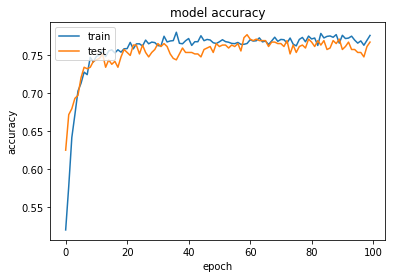

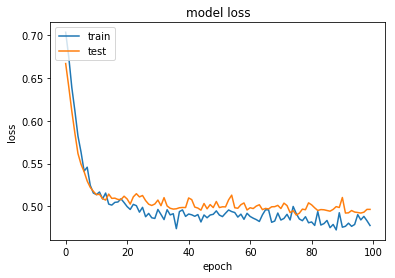

In [28]:
Baseline.validation_accuracy_loss(h_clf)

### Accuracy

In [29]:
result = { }

In [30]:
number_of_pairs = len(baseline.test_data)

#### train

In [31]:
from sklearn.metrics import accuracy_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, number_of_pairs, 1, 
                                                                             bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_train = accuracy_score(y_true, y_scores)
acc_train

0.7796848066978577

#### test

In [32]:
from sklearn.metrics import accuracy_score

number_of_pairs = len(baseline.test_data)

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = experiment.batch_classification_test(TEST_PATH, BERT=False)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_test = accuracy_score(y_true, y_scores)
acc_test

0.6920169412228214

### Roc AUC/SCORE

#### train

In [33]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, 
                                                                             number_of_pairs, 1, bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

roc_train = roc_auc_score(y_true, y_scores)
roc_train

0.8556846523173658

#### test

In [34]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = experiment.batch_classification_test(TEST_PATH, BERT=False)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

roc_test = roc_auc_score(y_true, y_scores)
roc_test

0.7582040935299108

In [35]:
pred = np.argmax(y_scores, axis=1)
pred = pred.tolist()
pred

[0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,


In [36]:
label = np.argmax(y_true, axis=1)
label = label.tolist()
label

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


Normalized confusion matrix
[[0.68964074 0.31035926]
 [0.30560686 0.69439314]]


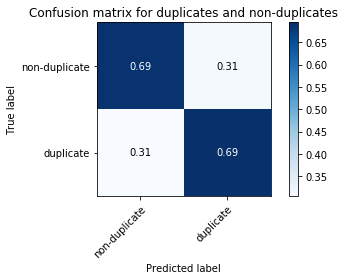

In [37]:
import matplotlib.pyplot as plt

ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['non-duplicate', 'duplicate']), 
                      title='Confusion matrix for duplicates and non-duplicates', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}.png'.format(DOMAIN, METHOD), bbox_inches="tight")

Normalized confusion matrix
[[0.68964074 0.31035926]
 [0.30560686 0.69439314]]


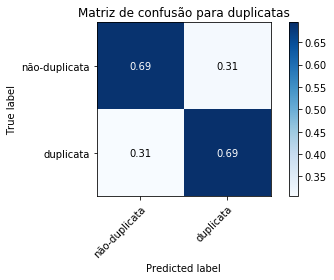

In [38]:
import matplotlib.pyplot as plt

ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['não-duplicata', 'duplicata']), 
                      title='Matriz de confusão para duplicatas', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}_pt.png'.format(DOMAIN, METHOD), bbox_inches="tight")

#### Save the model

In [39]:
experiment.save_model(model_clf, SAVE_PATH)

#### Saving the accuracy and roc/auc

In [42]:
import _pickle as pickle

CLASSIFICATION_PATH = 'classification_{}.pkl'.format(METHOD)

def save_result(result):
    result = {
        'acc_train' : acc_train,
        'acc_test' : acc_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
        'method' : METHOD
    }

    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'wb') as f:
        pickle.dump(result, f)

try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

All saved.


In [43]:
result

{'acc_test': 0.6920169412228214,
 'acc_train': 0.7796848066978577,
 'method': 'baseline_dwen_1000',
 'roc_test': 0.7582040935299108,
 'roc_train': 0.8556846523173658}